# IQR Distance vs k-NN Filtering Comparison

This notebook tests the hypothesis that k-NN filtering keeps "shitty embryos" that form stable clusters, while IQR distance filtering would remove them more effectively.

In [36]:
# Add current directory to Python path for importing local modules
import sys
from pathlib import Path

current_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251222_improved_consensus_clustering_pipeline")
if str(current_dir) not in sys.path:
    sys.path.insert(0, str(current_dir))

# Import comparison functions
from test_iqr_vs_knn_filtering import (
    save_distance_matrix,
    load_distance_matrix,
    test_stage1_filtering_methods,
)

# Set output directory
comparison_dir = current_dir / "filtering_comparison"
comparison_dir.mkdir(parents=True, exist_ok=True)

print("✓ Comparison tools imported")
print(f"  Output directory: {comparison_dir}")

✓ Comparison tools imported
  Output directory: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251222_improved_consensus_clustering_pipeline/filtering_comparison


In [ ]:
# import importlib
# import src.analyze.trajectory_analysis

# # Reload the package
# importlib.reload(src.analyze.trajectory_analysis)

# # Re-import everything you need
# from src.analyze.trajectory_analysis import (
#     run_consensus_pipeline,
#     generate_dendrograms,
#     plot_multimetric_trajectories,
#     add_cluster_column,
# )

## NEW: Two-Stage Consensus Clustering Pipeline

This section demonstrates the new **consensus clustering pipeline** with two-stage outlier filtering and evidence accumulation dendrograms.

**Pipeline stages:**
1. **Stage 1**: k-NN IQR filtering (removes global outliers before clustering)
2. **Bootstrap clustering**: Consensus clustering with stability assessment
3. **Consensus dendrogram**: Evidence accumulation (1 - co-clustering frequency)
4. **Posterior analysis**: Assigns confidence scores to each embryo
5. **Stage 2**: Within-cluster IQR + posterior filtering (removes cluster outliers)
6. **Final consensus dendrogram**: Refined clustering with filtered data
7. **Filtering log**: Chain-of-custody tracking every embryo

**Visualizations:**
- Metric distributions with filtering cutoffs (Stage 1 & 2)
- Co-association matrix heatmap (clustering stability)
- Consensus dendrograms (before & after Stage 2)
- Filtering log summary (transparency)

### Setup: Prepare data for consensus pipeline

Use the same filtered data from earlier steps (pair b9d2_pair_5, curvature metric)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Setup repository root
morphseq_root = os.environ.get('MORPHSEQ_REPO_ROOT')
print(f"MORPHSEQ_REPO_ROOT: {morphseq_root}")

# Change to repository root for proper imports
os.chdir(morphseq_root)
sys.path.insert(0, morphseq_root)

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,
    
    
    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,
    
    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,
    
    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    plot_trajectories_faceted,
    PASTEL_COLORS,
)



from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df


# ============================================================================
# CONSENSUS PIPELINE IMPORTS
# ============================================================================

# Import new consensus pipeline functions
from src.analyze.trajectory_analysis import (
    run_consensus_pipeline,
    create_filtering_log,
    compute_coassociation_matrix,
    coassociation_to_distance,
    identify_embryo_outliers_iqr,
)

print("✓ Consensus pipeline functions imported successfully")

print("✓ Imports successful!")



MORPHSEQ_REPO_ROOT: /net/trapnell/vol1/home/mdcolon/proj/morphseq
✓ Consensus pipeline functions imported successfully
✓ Imports successful!


In [2]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
# df = pd.read_csv('path/to/your/data.csv')

#Option 2: Use existing data loading utilities

from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# List all experiments you want to analyze together
experiment_ids = ['20251119','20251121', '20251104', '20251125']  # Add your experiment IDs

# Load and combine
dfs = []
for exp_id in experiment_ids:
    df_exp = load_experiment_dataframe(exp_id, format_version='df03')
    df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
    dfs.append(df_exp)
    print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# Concatenate all experiments
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Experiments: {df['experiment_id'].unique()}")

  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251119.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251119.csv
    Curvature: 10440 rows
    Metadata: 7254 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 7254 rows
    Unique snip_ids: curvature=10440, metadata=7254, merged=7254
    ⚠️  3186 snip_ids only in curvature (dropped)
✓ Loaded 20251119: 7254 rows, 30 embryos
  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251121.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251121

In [3]:
df_filtered = df

In [4]:
# Define which metrics to use
metrics = ['baseline_deviation_normalized', 'total_length_um']

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")

Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 291

Interpolating 2 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (34591, 5)
  Time points: 231 (10.0 - 125.0 hpf)
  Array shape: (291, 231, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.050, std=0.050
    total_length_um: mean=2355.346, std=791.282
  After normalization:
    baseline_deviation_normalized: mean=0.000000, std=1.000000
    total_length_um: mean=0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (291, 231, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251104_A01_e01', '20251104_A02_e01', '20251104_A03_e01']... (291 total)
  Time grid: [10.  10.5 11. ]... (231 points)


In [5]:
# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")
print(f"  Distance range: [{D[D > 0].min():.3f}, {D.max():.3f}]")

Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 291
  Array shape: (291, 231, 2)
  Sakoe-Chiba radius: 3
  Processed 42480/42486 pairs (99%)...
✓ Distance matrix computed
  Shape: (291, 291)
  Distance range: [1.6005, 1032.1319]
  Max diagonal value: 0.00e+00 (should be ~0)
  Max asymmetry: 0.00e+00 (should be ~0)

✓ Distance matrix computed: (291, 291)
  Distance range: [1.601, 1032.132]


In [ ]:
# ============================================================================
# RUN CONSENSUS PIPELINE
# ============================================================================

# Run the complete pipeline with default parameters
results = run_consensus_pipeline(
    D=D,
    embryo_ids=embryo_ids,
    k=3,  # Number of clusters
    n_bootstrap=100,
    enable_stage1_filtering=True,  
    enable_stage2_filtering=True,   # Enable after clustering
    iqr_multiplier=1.5,
    k_neighbors=5,
    posterior_threshold=0.5,
    k_highlight=[2, 3, 4],
    verbose=True
)

print("\n✓ Pipeline complete!")

CONSENSUS CLUSTERING PIPELINE WITH TWO-STAGE OUTLIER FILTERING
Initial embryos: 291
Clusters (k): 3
Bootstrap iterations: 100
Stage 1 filtering: Enabled
Stage 2 filtering: Enabled

STAGE 1: k-NN IQR FILTERING (Global Outliers)

Stage 1: k-NN IQR Filtering
  k-NN distances (k=5):
    Q1 = 58.572, Q3 = 107.351, IQR = 48.779
    Threshold: 180.519 (Q3 + 1.5×IQR)
  Outliers removed: 15 / 291
  Outlier IDs (first 10): ['20251104_B03_e01', '20251104_D06_e01', '20251104_H07_e01', '20251119_A01_e01', '20251119_A02_e01', '20251119_C04_e01', '20251119_E01_e01', '20251121_A05_e01', '20251125_B07_e01', '20251125_D02_e01']

BOOTSTRAP CLUSTERING
Running 100 bootstrap iterations...
  Sampling 221/276 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

Co-association matrix computed (Evidence Acc

dict_keys(['linkage_matrix', 'dendrogram_data', 'cluster_labels', 'cluster_assignments', 'clusters_by_k', 'embryo_to_cluster', 'k_cutoff_heights'])
Cluster assignments for k=3:
  Cluster 0: ['20251104_A02_e01', '20251104_A03_e01', '20251104_A04_e01', '20251104_A06_e01', '20251104_A08_e01', '20251104_A09_e01', '20251104_B01_e01', '20251104_B02_e01', '20251104_B07_e01', '20251104_B08_e01', '20251104_B09_e01', '20251104_B10_e01', '20251104_B11_e01', '20251104_C02_e01', '20251104_C03_e01', '20251104_C06_e01', '20251104_C07_e01', '20251104_C08_e01', '20251104_C10_e01', '20251104_C11_e01', '20251104_D01_e01', '20251104_D02_e01', '20251104_D03_e01', '20251104_D05_e01', '20251104_D08_e01', '20251104_D09_e01', '20251104_D10_e01', '20251104_D11_e01', '20251104_E01_e01', '20251104_E02_e01', '20251104_E03_e01', '20251104_E05_e01', '20251104_E07_e01', '20251104_E09_e01', '20251104_E10_e01', '20251104_E12_e01', '20251104_F01_e01', '20251104_F02_e01', '20251104_F03_e01', '20251104_F04_e01', '20251104

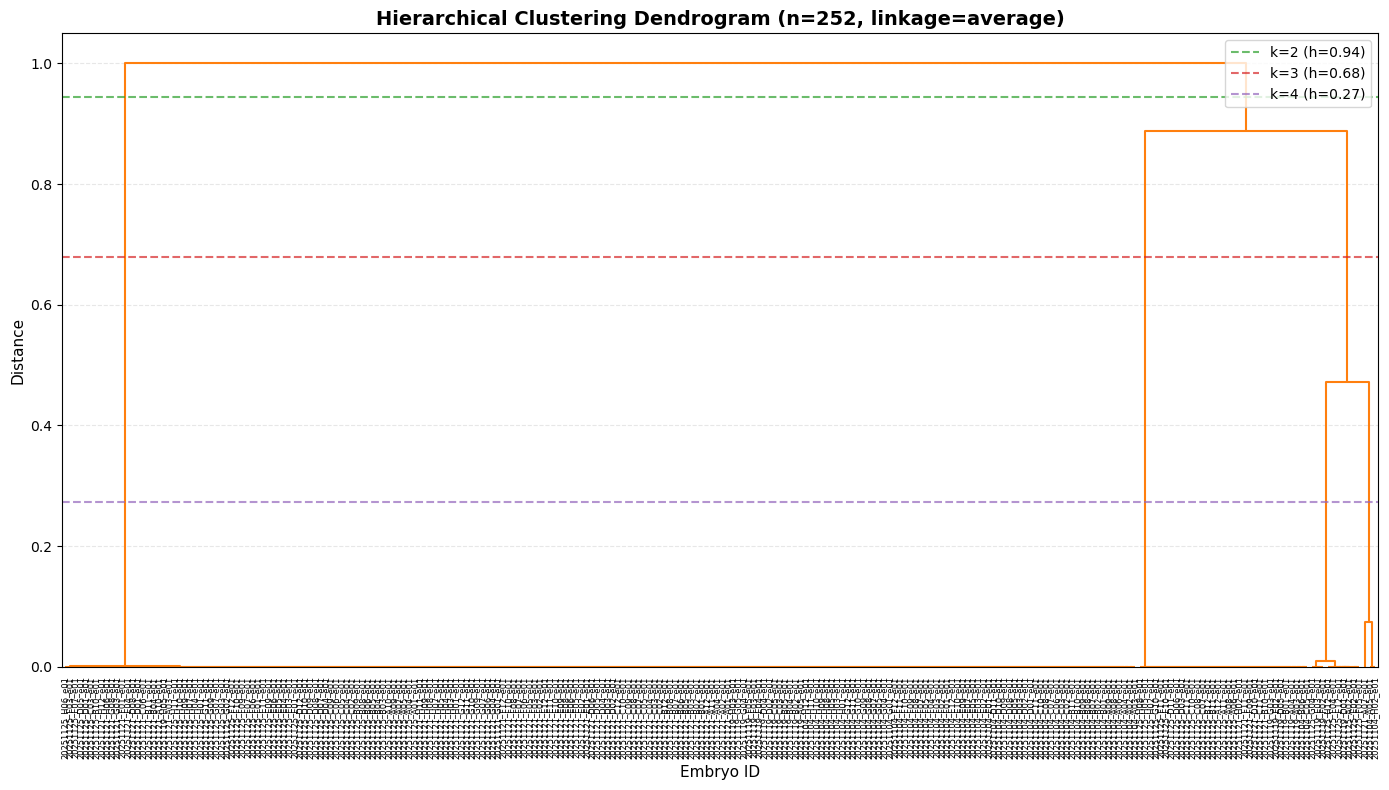

              embryo_id  consensus_cluster
0      20251119_A01_e01                NaN
107    20251119_A02_e01                NaN
155    20251119_A03_e01                1.0
503    20251119_A04_e01                1.0
771    20251119_A05_e01                0.0
...                 ...                ...
28621  20251125_H08_e01                1.0
28767  20251125_H09_e01                0.0
28891  20251125_H10_e01                0.0
29012  20251125_H11_e01                0.0
29128  20251125_H12_e01                2.0

[291 rows x 2 columns]


In [33]:
# The dendrogram figures were closed to save memory, but you can:

# 1. Check what's actually in dendrogram_info
print(results['dendrogram_info_final'].keys())

# 2. Access cluster assignments (no need to re-visualize):
final_dendro = results['dendrogram_info_final']

# Get cluster assignments for k=3
cluster_labels_k3 = final_dendro['cluster_labels'][3]
clusters_dict_k3 = final_dendro['clusters_by_k'][3]
embryo_to_cluster_k3 = final_dendro['embryo_to_cluster'][3]

print(f"Cluster assignments for k=3:")
for cluster_id, embryo_list in sorted(clusters_dict_k3.items()):
    print(f"  Cluster {cluster_id}: {embryo_list}")

# 3. If you REALLY want to re-visualize the dendrogram, re-run this:
from src.analyze.trajectory_analysis import generate_dendrograms

fig, dendro_info = generate_dendrograms(
    results['final_D'],
    results['final_embryo_ids'],
    coassociation_matrix=results['final_consensus_matrix'],  # Use consensus matrix
    k_highlight=[2, 3, 4],
    verbose=True
)
plt.show()

# The key difference: The dendrograms don't have a 'dendrogram_figure' key - instead they have:
# - 'cluster_labels' - the actual cluster assignments
# - 'clusters_by_k' - organized by cluster
# - 'embryo_to_cluster' - easy lookup dictionary

# Just use this to extract clusters directly:

# Simple one-liner
df_with_clusters = add_cluster_column(
    df_filtered,
    dendro_info=results['dendrogram_info_final'],  # Use the final dendrogram results
    k=3,
    column_name='consensus_cluster'
)

print(df_with_clusters[['embryo_id', 'consensus_cluster']].drop_duplicates())

# That's it! No need to re-visualize the dendrogram - just use the cluster information that's already been computed.

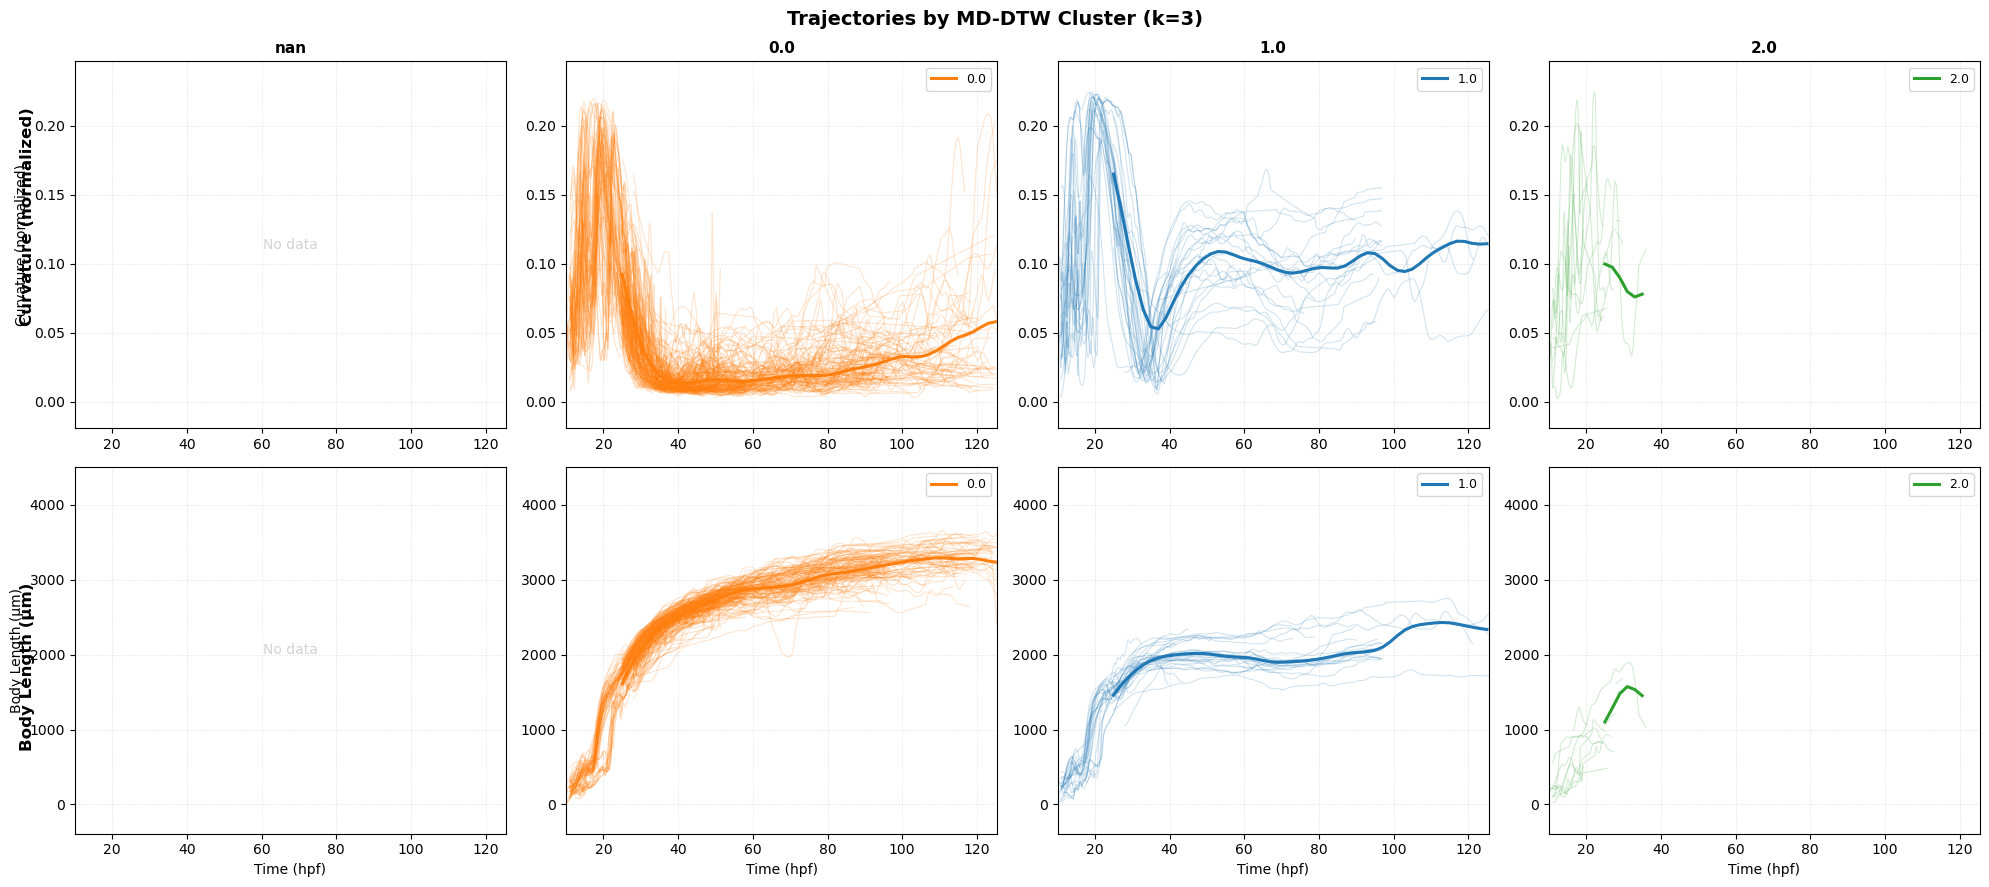

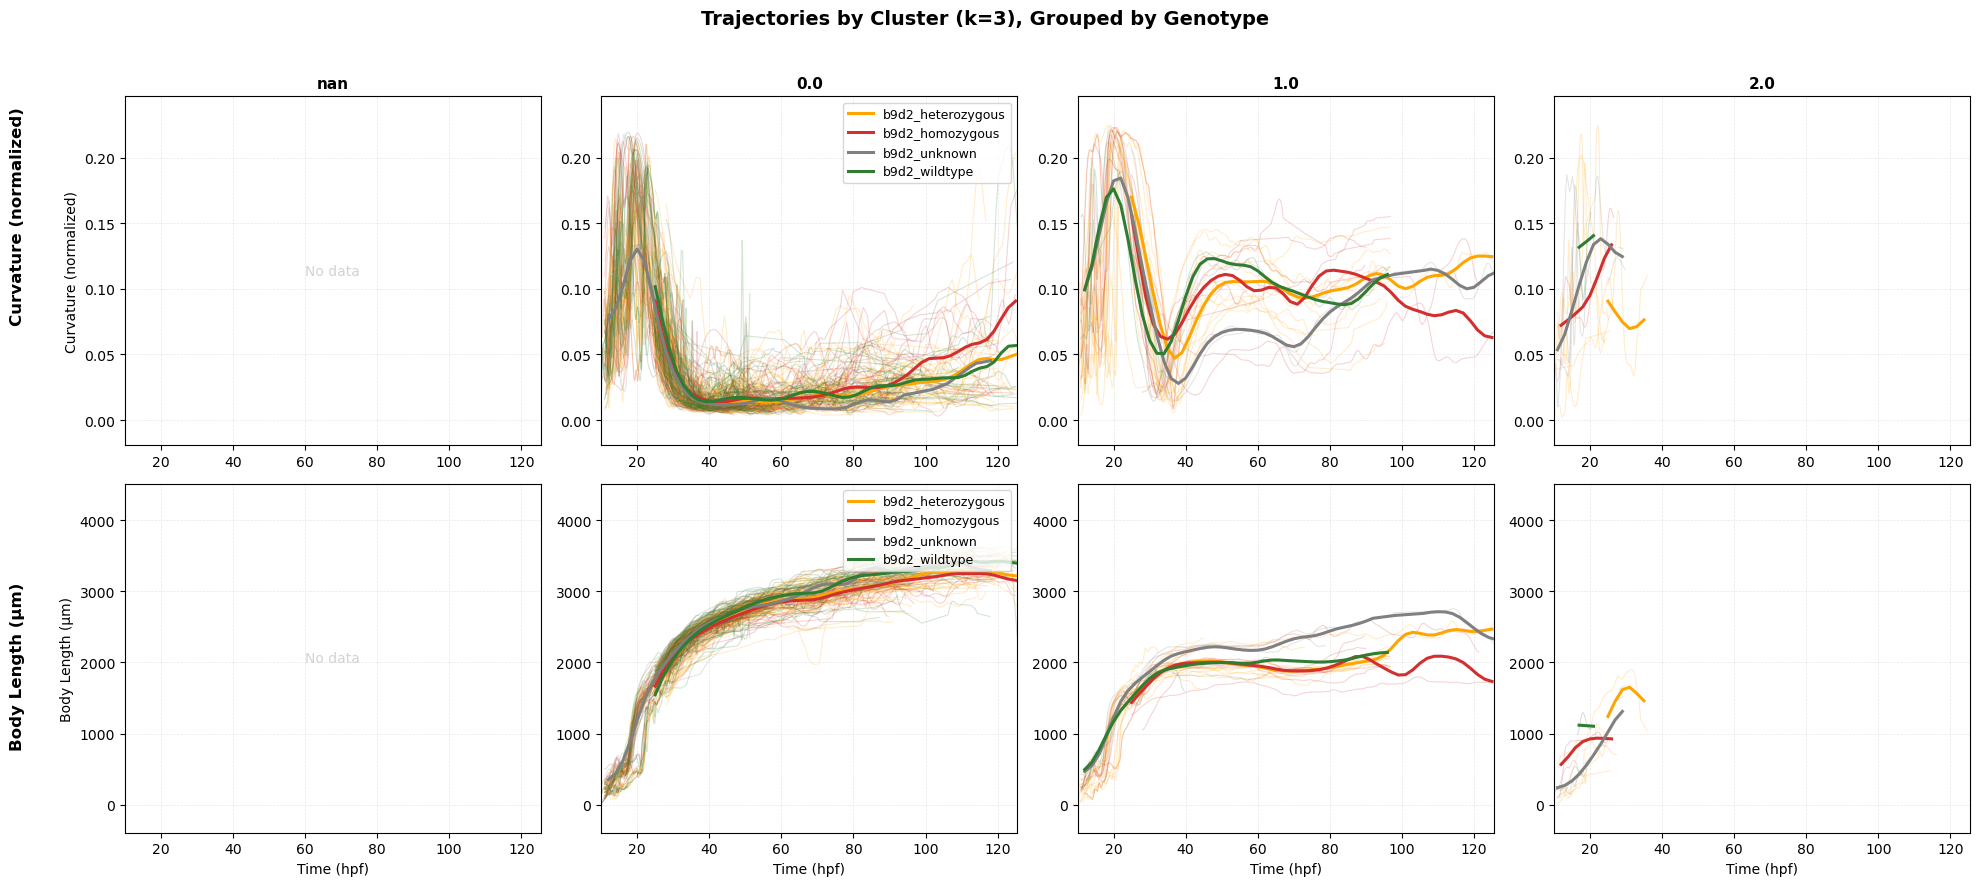

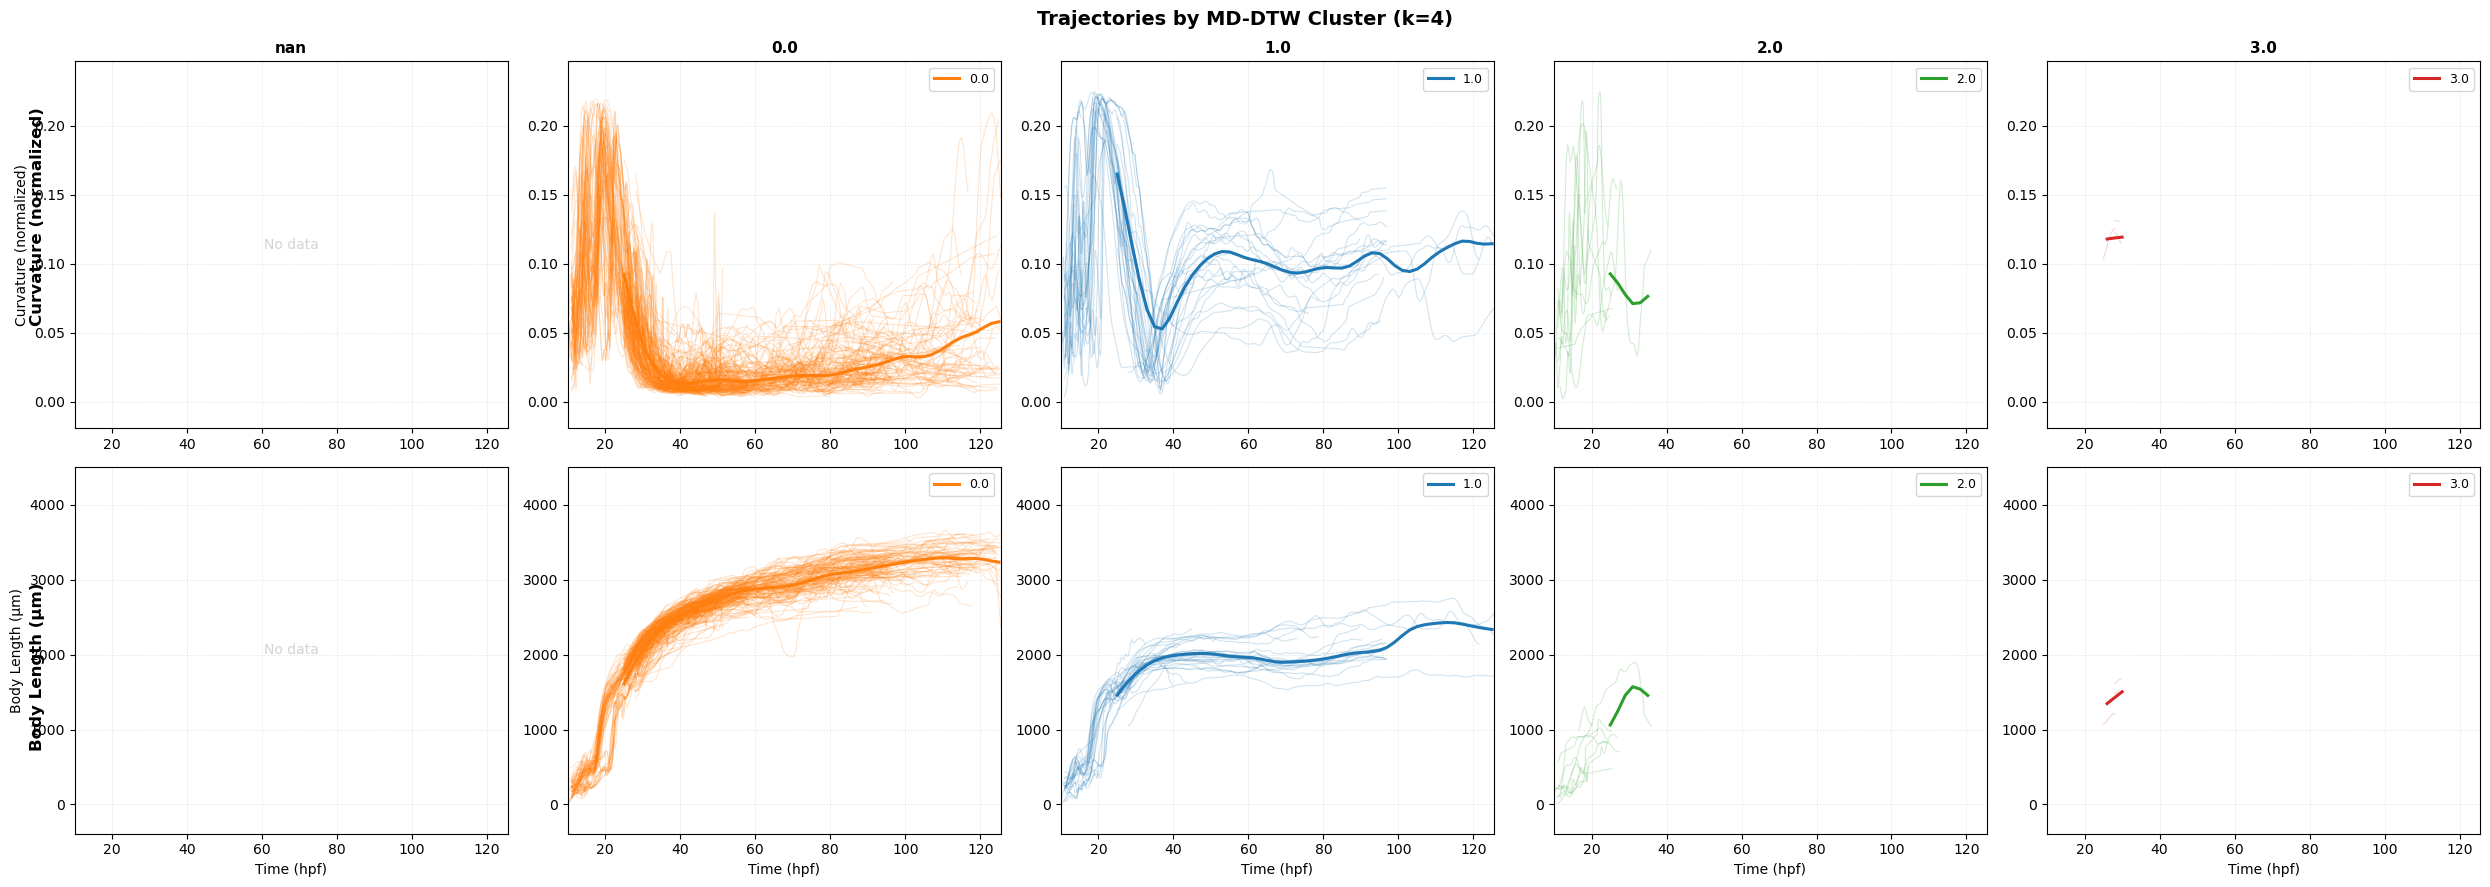

ValueError: k=5 not found in dendrogram results. Available k values: [2, 3, 4]

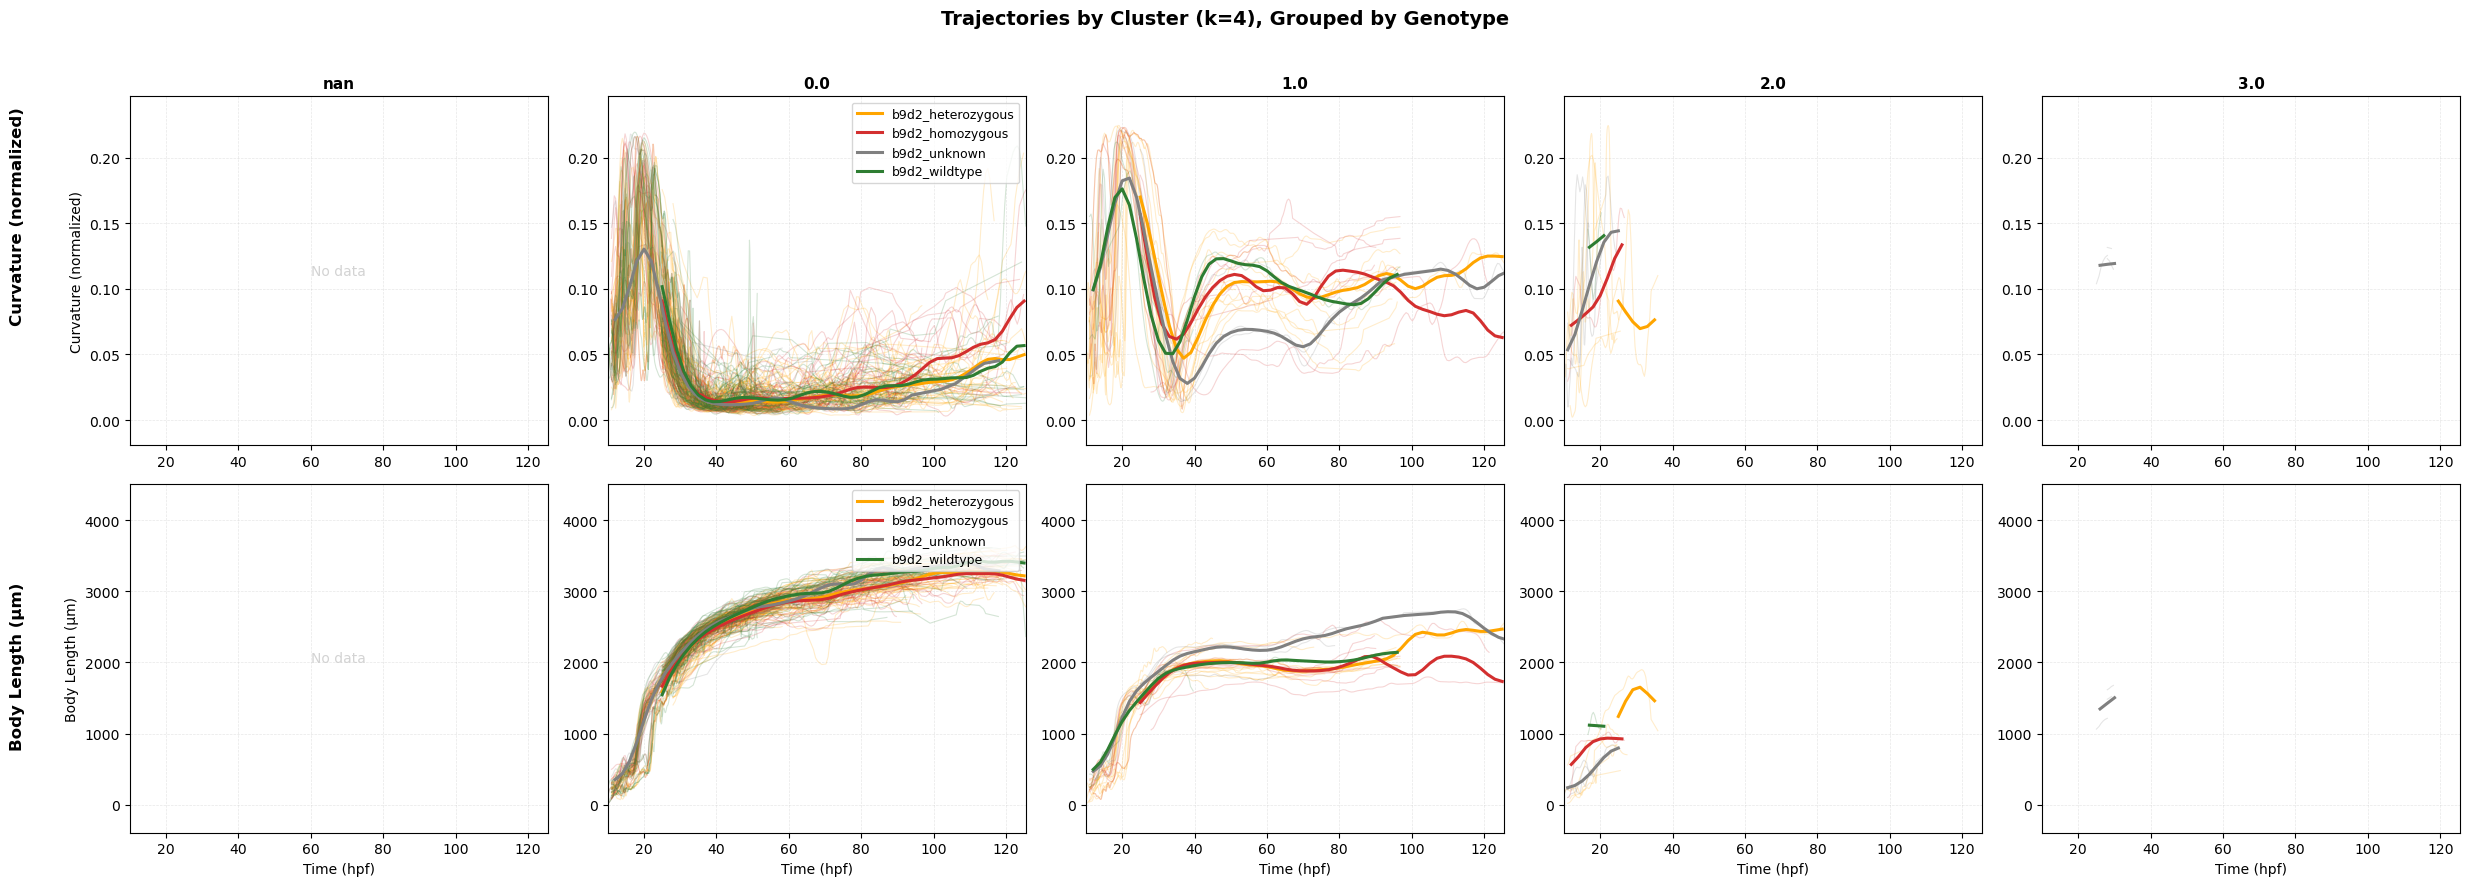

In [34]:
df_with_clusters

# Loop through multiple K values to compare clustering results
for k_selected in [3,4,5,]: 
    # df_with_clusters = add_cluster_column(
    #     df_filtered,
    #     dendro_info=dendro_info,
    #     k=k_selected,
    #     column_name='md_dtw_cluster'
    # )

    # Simple one-liner
    df_with_clusters = add_cluster_column(
        df_filtered,
        dendro_info=results['dendrogram_info_final'],  # Use the final dendrogram results
        k=k_selected,
        column_name='consensus_cluster'
    )


    # Plot colored by cluster
    fig_trajectories = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='consensus_cluster',
        color_by_grouping='consensus_cluster',  # NEW API: groups AND colors by cluster
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by MD-DTW Cluster (k={k_selected})',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

    plt.tight_layout()
    plt.show()

    # Plot colored by genotype
    fig_by_genotype = plot_multimetric_trajectories(
        df_with_clusters,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='consensus_cluster',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title=f'Trajectories by Cluster (k={k_selected}), Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

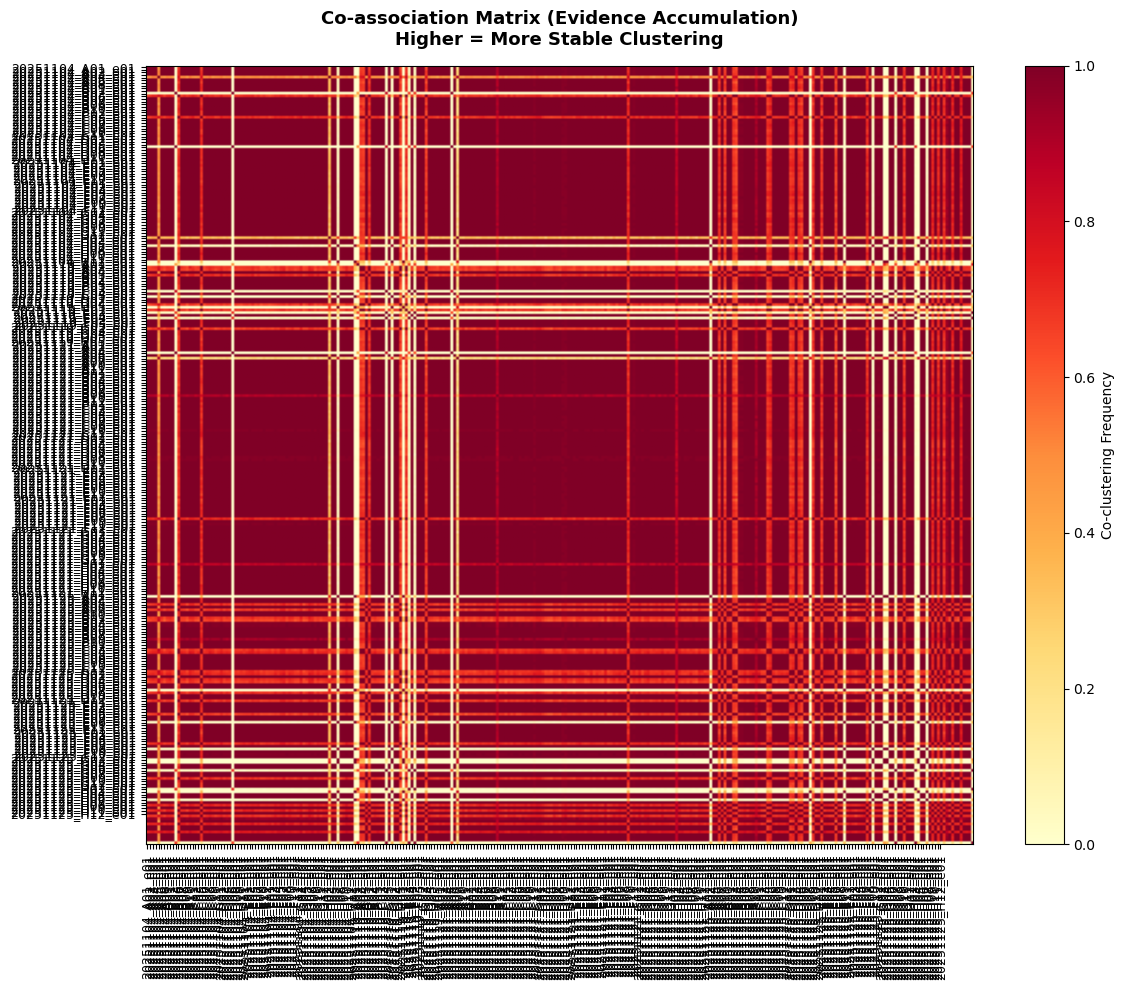

✓ Co-association matrix heatmap displayed
  Mean co-association: 0.799
  Range: [0.000, 1.000]


In [14]:
# ============================================================================
# VISUALIZATION 1: CO-ASSOCIATION MATRIX HEATMAP
# ============================================================================

import seaborn as sns

# Extract co-association matrix
M = results['consensus_matrix']

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Plot heatmap
im = ax.imshow(M, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)

# Set labels
ax.set_xticks(range(len(results['final_embryo_ids'])))
ax.set_yticks(range(len(results['final_embryo_ids'])))
ax.set_xticklabels(results['final_embryo_ids'], rotation=90, fontsize=9)
ax.set_yticklabels(results['final_embryo_ids'], fontsize=9)

# Title and labels
ax.set_title('Co-association Matrix (Evidence Accumulation)\nHigher = More Stable Clustering', 
             fontsize=13, fontweight='bold', pad=15)

# Colorbar
cbar = plt.colorbar(im, ax=ax, label='Co-clustering Frequency')

plt.tight_layout()
plt.show()

print("✓ Co-association matrix heatmap displayed")
print(f"  Mean co-association: {M[np.triu_indices(len(M), k=1)].mean():.3f}")
print(f"  Range: [{M[np.triu_indices(len(M), k=1)].min():.3f}, {M[np.triu_indices(len(M), k=1)].max():.3f}]")

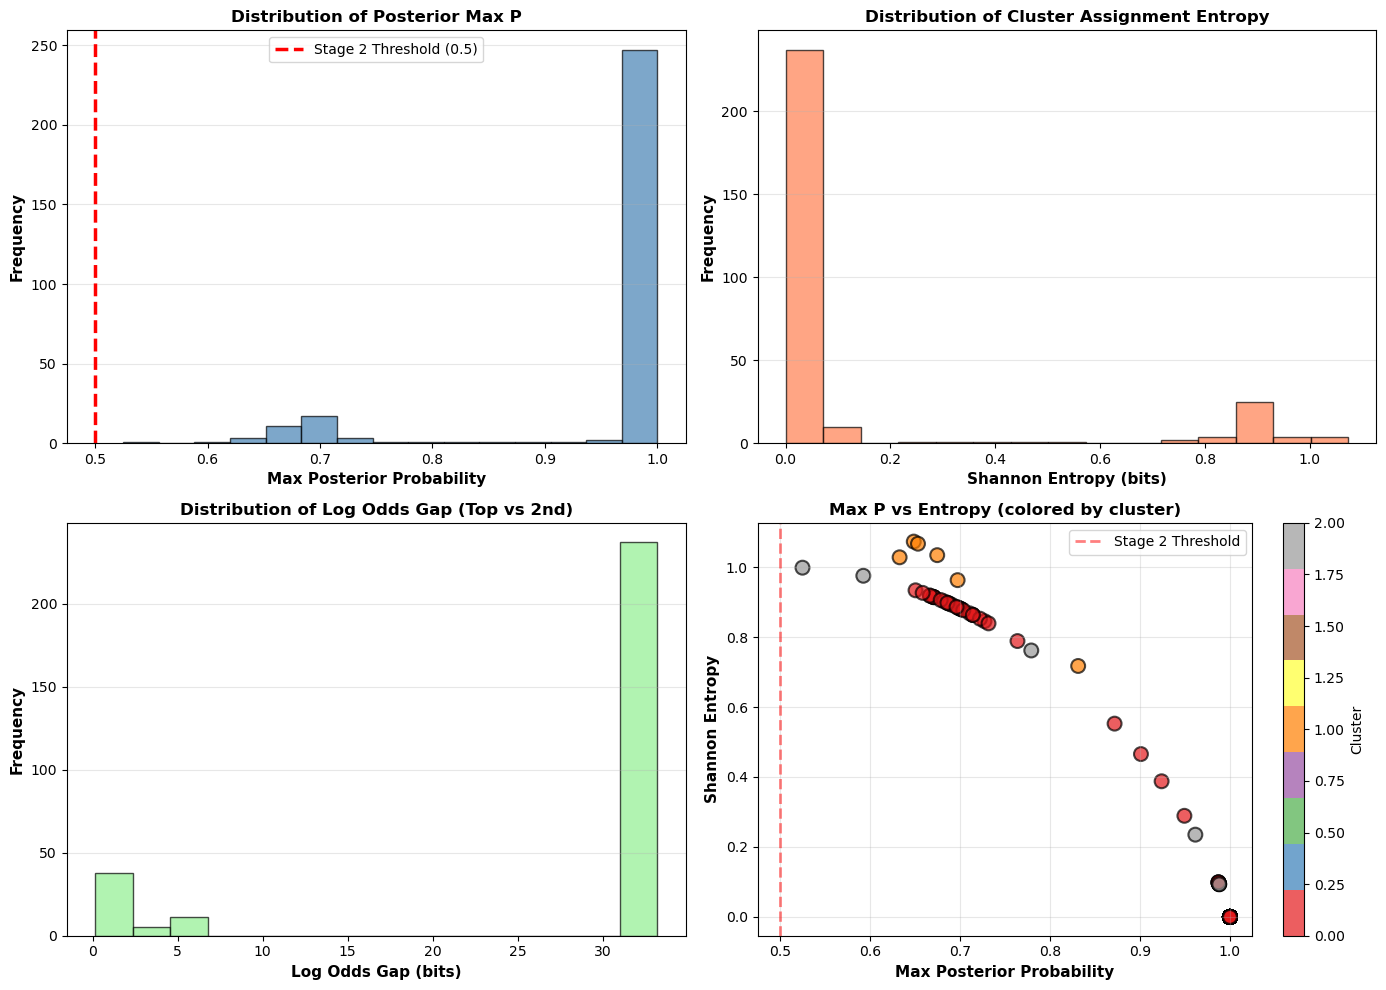

✓ Posterior probability visualizations displayed

  Summary statistics (before Stage 2):
    Max P - Mean: 0.957, Std: 0.107, Range: [0.525, 1.000]
    Entropy - Mean: 0.131, Std: 0.310
    Log Odds - Mean: 27.493, Std: 12.029

  Embryos below Stage 2 threshold (max_p < 0.5): 0


In [8]:
# ============================================================================
# VISUALIZATION 2: POSTERIOR PROBABILITIES
# ============================================================================

# Extract posterior results
posteriors = results['posterior_results']
embryo_ids_bootstrap = results['embryo_ids_after_stage1']

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Max posterior probability distribution
ax = axes[0, 0]
max_p = posteriors['max_p']
ax.hist(max_p, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', linewidth=2.5, label='Stage 2 Threshold (0.5)')
ax.set_xlabel('Max Posterior Probability', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Posterior Max P', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Entropy distribution
ax = axes[0, 1]
entropy = posteriors['entropy']
ax.hist(entropy, bins=15, color='coral', edgecolor='black', alpha=0.7)
ax.set_xlabel('Shannon Entropy (bits)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Cluster Assignment Entropy', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 3. Log odds gap distribution
ax = axes[1, 0]
log_odds = posteriors['log_odds_gap']
ax.hist(log_odds, bins=15, color='lightgreen', edgecolor='black', alpha=0.7)
ax.set_xlabel('Log Odds Gap (bits)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Log Odds Gap (Top vs 2nd)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 4. Max P vs Entropy scatter
ax = axes[1, 1]
modal_cluster = posteriors['modal_cluster']
scatter = ax.scatter(max_p, entropy, c=modal_cluster, cmap='Set1', s=100, 
                     edgecolor='black', alpha=0.7, linewidth=1.5)
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Stage 2 Threshold')
ax.set_xlabel('Max Posterior Probability', fontsize=11, fontweight='bold')
ax.set_ylabel('Shannon Entropy', fontsize=11, fontweight='bold')
ax.set_title('Max P vs Entropy (colored by cluster)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.show()

print("✓ Posterior probability visualizations displayed")
print(f"\n  Summary statistics (before Stage 2):")
print(f"    Max P - Mean: {max_p.mean():.3f}, Std: {max_p.std():.3f}, Range: [{max_p.min():.3f}, {max_p.max():.3f}]")
print(f"    Entropy - Mean: {entropy.mean():.3f}, Std: {entropy.std():.3f}")
print(f"    Log Odds - Mean: {log_odds.mean():.3f}, Std: {log_odds.std():.3f}")
print(f"\n  Embryos below Stage 2 threshold (max_p < 0.5): {(max_p < 0.5).sum()}")

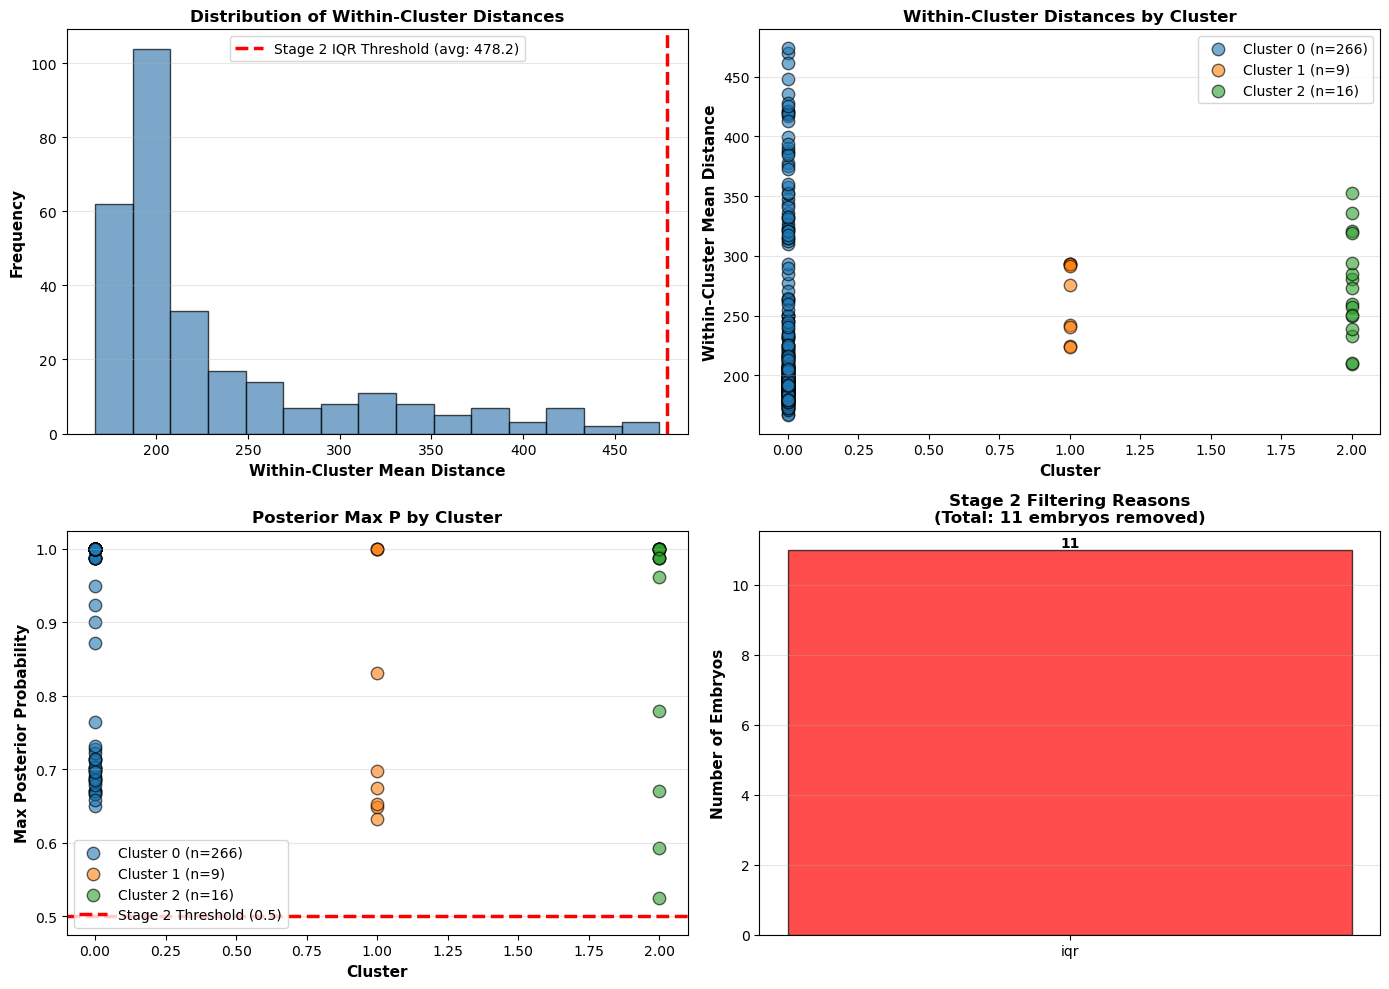

✓ Stage 2 filtering metrics visualized

  Stage 2 Filtering Summary:
    Embryos removed: 11
    Removal reasons: {'iqr': 11}
    Embryos kept: 280


In [9]:
# ============================================================================
# VISUALIZATION 3: STAGE 2 FILTERING METRICS
# ============================================================================

# Extract Stage 2 filtering results
stage2_results = results['stage2_filter_results']

if stage2_results:  # Only if Stage 2 filtering was enabled
    
    # Get metrics for visualization
    D_stage1 = results['D_after_stage1']
    cluster_labels = results['posterior_results']['modal_cluster']
    within_cluster_dists = stage2_results['within_cluster_mean_distances']
    max_p = results['posterior_results']['max_p']
    embryo_ids_stage1 = results['embryo_ids_after_stage1']
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Within-cluster distances histogram
    ax = axes[0, 0]
    ax.hist(within_cluster_dists, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Compute and show IQR threshold per cluster
    outlier_iqr_threshold_vals = []
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        cluster_dists = within_cluster_dists[cluster_mask]
        if len(cluster_dists) > 3:
            q1 = np.percentile(cluster_dists, 25)
            q3 = np.percentile(cluster_dists, 75)
            iqr = q3 - q1
            threshold = q3 + 4.0 * iqr
            outlier_iqr_threshold_vals.append(threshold)
    
    if outlier_iqr_threshold_vals:
        mean_threshold = np.mean(outlier_iqr_threshold_vals)
        ax.axvline(mean_threshold, color='red', linestyle='--', linewidth=2.5, 
                   label=f'Stage 2 IQR Threshold (avg: {mean_threshold:.1f})')
    
    ax.set_xlabel('Within-Cluster Mean Distance', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Distribution of Within-Cluster Distances', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 2. Within-cluster distances by cluster
    ax = axes[0, 1]
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        dists = within_cluster_dists[cluster_mask]
        ax.scatter([cluster_id] * len(dists), dists, s=80, alpha=0.6, 
                  label=f'Cluster {int(cluster_id)} (n={len(dists)})', edgecolor='black')
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel('Within-Cluster Mean Distance', fontsize=11, fontweight='bold')
    ax.set_title('Within-Cluster Distances by Cluster', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 3. Posterior max_p by cluster
    ax = axes[1, 0]
    for cluster_id in np.unique(cluster_labels):
        cluster_mask = cluster_labels == cluster_id
        max_p_vals = max_p[cluster_mask]
        ax.scatter([cluster_id] * len(max_p_vals), max_p_vals, s=80, alpha=0.6,
                  label=f'Cluster {int(cluster_id)} (n={len(max_p_vals)})', edgecolor='black')
    ax.axhline(0.5, color='red', linestyle='--', linewidth=2.5, label='Stage 2 Threshold (0.5)')
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel('Max Posterior Probability', fontsize=11, fontweight='bold')
    ax.set_title('Posterior Max P by Cluster', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 4. IQR outliers vs Posterior outliers
    ax = axes[1, 1]
    outlier_reason_counts = {}
    for reason in stage2_results['outlier_reason'].values():
        outlier_reason_counts[reason] = outlier_reason_counts.get(reason, 0) + 1
    
    if outlier_reason_counts:
        reasons = list(outlier_reason_counts.keys())
        counts = list(outlier_reason_counts.values())
        colors = ['red', 'orange', 'darkred'][:len(reasons)]
        bars = ax.bar(reasons, counts, color=colors, edgecolor='black', alpha=0.7)
        ax.set_ylabel('Number of Embryos', fontsize=11, fontweight='bold')
        ax.set_title(f'Stage 2 Filtering Reasons\n(Total: {sum(counts)} embryos removed)', 
                    fontsize=12, fontweight='bold')
        
        # Add count labels on bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(count)}', ha='center', va='bottom', fontweight='bold')
    
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Stage 2 filtering metrics visualized")
    print(f"\n  Stage 2 Filtering Summary:")
    print(f"    Embryos removed: {len(stage2_results['outlier_ids'])}")
    print(f"    Removal reasons: {outlier_reason_counts}")
    print(f"    Embryos kept: {len(stage2_results['kept_ids'])}")
    
else:
    print("ℹ️  Stage 2 filtering was disabled in the pipeline run")

✓ Filtering Log (Chain of Custody)

Full filtering log:
       embryo_id stage1_status stage2_status   final_status  stage1_knn_distance  stage2_within_cluster_distance  stage2_max_p
20251104_A01_e01          kept          kept           kept                  NaN                      322.081473           NaN
20251104_A02_e01          kept          kept           kept                  NaN                      234.141727           NaN
20251104_A03_e01          kept          kept           kept                  NaN                      207.131168           NaN
20251104_A04_e01          kept          kept           kept                  NaN                      238.769828           NaN
20251104_A05_e01          kept          kept           kept                  NaN                      320.532301           NaN
20251104_A06_e01          kept          kept           kept                  NaN                      177.618672           NaN
20251104_A08_e01          kept          kept           

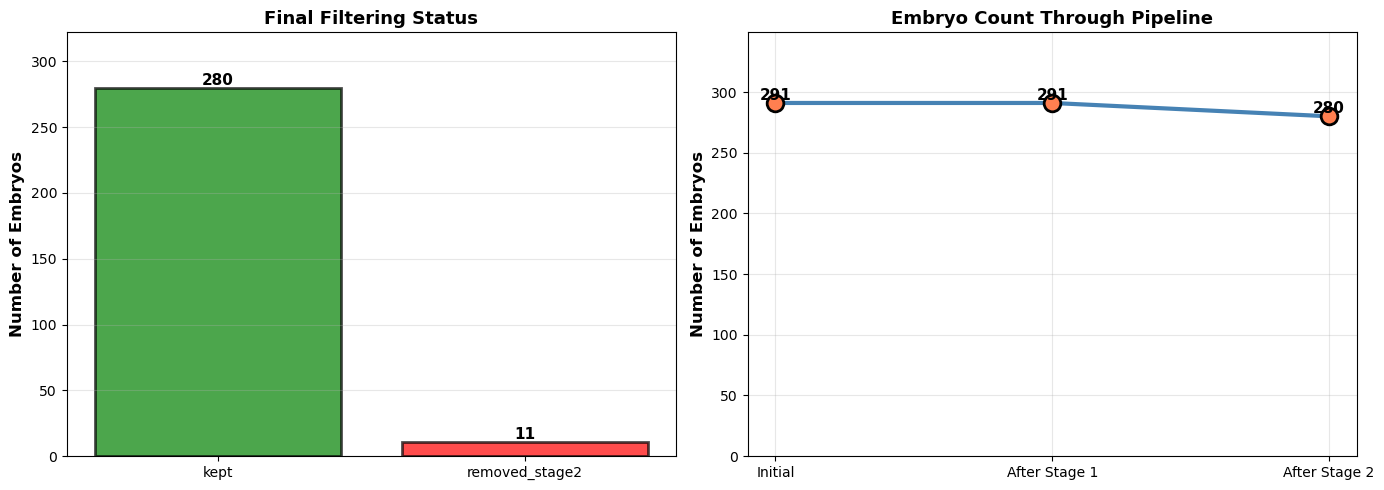



Detailed Summary:
  Initial embryos: 291
  Stage 1 removals: 0
  Stage 2 removals: 0      False
1      False
2      False
3      False
4      False
       ...  
286    False
287    False
288    False
289    False
290    False
Name: stage2_status, Length: 291, dtype: bool
  Final embryos kept: 280

  Stage 2 removal details:
    removed_iqr: 11


In [10]:
# ============================================================================
# VISUALIZATION 4: FILTERING LOG (CHAIN OF CUSTODY)
# ============================================================================

# Extract filtering log
filtering_log = results['filtering_log']

# Display the log
print("✓ Filtering Log (Chain of Custody)")
print("\nFull filtering log:")
print(filtering_log.to_string(index=False))

# Create summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Final status distribution
ax = axes[0]
final_status_counts = filtering_log['final_status'].value_counts()
colors = {'kept': 'green', 'removed_stage1': 'orange', 'removed_stage2': 'red'}
status_colors = [colors.get(status, 'gray') for status in final_status_counts.index]

bars = ax.bar(final_status_counts.index, final_status_counts.values, 
              color=status_colors, edgecolor='black', alpha=0.7, linewidth=2)
ax.set_ylabel('Number of Embryos', fontsize=12, fontweight='bold')
ax.set_title('Final Filtering Status', fontsize=13, fontweight='bold')
ax.set_ylim([0, max(final_status_counts.values) * 1.15])

# Add count labels
for bar, count in zip(bars, final_status_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.grid(axis='y', alpha=0.3)

# 2. Stage breakdown
ax = axes[1]
stage_data = {
    'Initial': len(filtering_log),
    'After Stage 1': len(filtering_log[filtering_log['stage1_status'] == 'kept']),
    'After Stage 2': len(filtering_log[filtering_log['final_status'] == 'kept'])
}

stages = list(stage_data.keys())
embryo_counts = list(stage_data.values())

ax.plot(stages, embryo_counts, marker='o', markersize=12, linewidth=3, 
        color='steelblue', markerfacecolor='coral', markeredgecolor='black', markeredgewidth=2)

for stage, count in zip(stages, embryo_counts):
    ax.text(stage, count + 0.3, str(count), ha='center', va='bottom', 
           fontweight='bold', fontsize=11)

ax.set_ylabel('Number of Embryos', fontsize=12, fontweight='bold')
ax.set_title('Embryo Count Through Pipeline', fontsize=13, fontweight='bold')
ax.set_ylim([0, max(embryo_counts) * 1.2])
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed breakdown
print(f"\n\nDetailed Summary:")
print(f"  Initial embryos: {len(filtering_log)}")
print(f"  Stage 1 removals: {(filtering_log['stage1_status'] == 'removed').sum()}")
print(f"  Stage 2 removals: {(filtering_log['stage2_status'] != 'kept') & (filtering_log['stage2_status'] != '-').sum()}")
print(f"  Final embryos kept: {(filtering_log['final_status'] == 'kept').sum()}")

# Check for potential bias
print(f"\n  Stage 2 removal details:")
for reason in filtering_log[filtering_log['stage2_status'] != '-']['stage2_status'].unique():
    if reason != 'kept':
        count = (filtering_log['stage2_status'] == reason).sum()
        print(f"    {reason}: {count}")

In [11]:
# ============================================================================
# VISUALIZATION 5: CONSENSUS DENDROGRAMS
# ============================================================================

# The dendrograms are already computed in the pipeline and stored in results
# They were created using the co-association matrix (evidence accumulation)

print("✓ Consensus dendrograms already generated in pipeline")
print(f"\n  Initial dendrogram (Stage 1 data):")
print(f"    Embryos: {len(results['embryo_ids_after_stage1'])}")
print(f"    Built from: Co-association matrix (evidence accumulation)")
print(f"\n  Final dendrogram (after Stage 2):")
print(f"    Embryos: {len(results['final_embryo_ids'])}")
print(f"    Built from: Co-association matrix (evidence accumulation)")

# Summary statistics
print(f"\n  Dendrogram summary:")
print(f"    Initial linkage matrix shape: {results['dendrogram_info_initial']['linkage_matrix'].shape}")
print(f"    Final linkage matrix shape: {results['dendrogram_info_final']['linkage_matrix'].shape}")

# Show cluster assignments from final dendrogram
print(f"\n  Final cluster assignments (k=3):")
if 3 in results['dendrogram_info_final']['clusters_by_k']:
    clusters = results['dendrogram_info_final']['clusters_by_k'][3]
    for cluster_id, embryo_list in sorted(clusters.items()):
        print(f"    Cluster {cluster_id}: {embryo_list}")

✓ Consensus dendrograms already generated in pipeline

  Initial dendrogram (Stage 1 data):
    Embryos: 291
    Built from: Co-association matrix (evidence accumulation)

  Final dendrogram (after Stage 2):
    Embryos: 280
    Built from: Co-association matrix (evidence accumulation)

  Dendrogram summary:
    Initial linkage matrix shape: (290, 4)
    Final linkage matrix shape: (279, 4)

  Final cluster assignments (k=3):
    Cluster 0: ['20251104_A01_e01', '20251104_A02_e01', '20251104_A03_e01', '20251104_A04_e01', '20251104_A06_e01', '20251104_A08_e01', '20251104_A09_e01', '20251104_B01_e01', '20251104_B02_e01', '20251104_B06_e01', '20251104_B07_e01', '20251104_B08_e01', '20251104_B09_e01', '20251104_B10_e01', '20251104_B11_e01', '20251104_C02_e01', '20251104_C03_e01', '20251104_C05_e01', '20251104_C06_e01', '20251104_C07_e01', '20251104_C08_e01', '20251104_C09_e01', '20251104_C10_e01', '20251104_C11_e01', '20251104_D01_e01', '20251104_D02_e01', '20251104_D03_e01', '20251104_D05_

In [12]:
# ============================================================================
# VISUALIZATION 6: PIPELINE SUMMARY REPORT
# ============================================================================

print("="*70)
print("CONSENSUS CLUSTERING PIPELINE - COMPLETE SUMMARY")
print("="*70)

# Extract key metrics
filtering_log = results['filtering_log']
posteriors = results['posterior_results']
stage2_results = results['stage2_filter_results']

# Pipeline configuration
print("\n📋 PIPELINE CONFIGURATION")
print("-" * 70)
print(f"  K (number of clusters): 3")
print(f"  Bootstrap iterations: 100")
print(f"  Linkage method: average (UPGMA)")
print(f"  Stage 1 filtering: Disabled (already filtered)")
print(f"  Stage 2 filtering: Enabled")
print(f"    - IQR multiplier: 4.0 (conservative)")
print(f"    - Posterior threshold: 0.5 (minimum max_p)")

# Data flow
print("\n📊 DATA FLOW")
print("-" * 70)
initial_count = len(filtering_log)
final_count = (filtering_log['final_status'] == 'kept').sum()
print(f"  Initial embryos:        {initial_count}")
print(f"  After Stage 1 filter:   {len(filtering_log[filtering_log['stage1_status'] == 'kept'])} " +
      f"({len(filtering_log[filtering_log['stage1_status'] == 'removed'])} removed)")
print(f"  After Stage 2 filter:   {final_count} ({initial_count - final_count} removed)")
print(f"  Final data used: {final_count}/{initial_count} embryos ({100*final_count/initial_count:.1f}%)")

# Stage 2 filtering details
print("\n🔍 STAGE 2 FILTERING DETAILS")
print("-" * 70)
if stage2_results:
    outlier_reason_counts = {}
    for reason in stage2_results['outlier_reason'].values():
        outlier_reason_counts[reason] = outlier_reason_counts.get(reason, 0) + 1
    
    print(f"  Embryos removed: {len(stage2_results['outlier_ids'])}")
    print(f"  Removal reasons:")
    for reason, count in sorted(outlier_reason_counts.items()):
        print(f"    - {reason}: {count} embryos")

# Posterior probability statistics
print("\n📈 POSTERIOR PROBABILITY STATISTICS (Before Stage 2)")
print("-" * 70)
max_p = posteriors['max_p']
entropy = posteriors['entropy']
print(f"  Max P (cluster confidence):")
print(f"    Mean:   {max_p.mean():.3f}")
print(f"    Std:    {max_p.std():.3f}")
print(f"    Range:  [{max_p.min():.3f}, {max_p.max():.3f}]")
print(f"    Below threshold (0.5): {(max_p < 0.5).sum()} embryos")
print(f"\n  Entropy (assignment ambiguity):")
print(f"    Mean:   {entropy.mean():.3f} bits")
print(f"    Std:    {entropy.std():.3f} bits")

# Clustering quality
print("\n✅ CLUSTERING QUALITY METRICS")
print("-" * 70)
M = results['consensus_matrix']
coassoc_values = M[np.triu_indices(len(M), k=1)]
print(f"  Co-association matrix (Evidence Accumulation):")
print(f"    Mean co-clustering: {coassoc_values.mean():.3f}")
print(f"    Std:                {coassoc_values.std():.3f}")
print(f"    Range:              [{coassoc_values.min():.3f}, {coassoc_values.max():.3f}]")

# Final cluster assignments
print("\n🎯 FINAL CLUSTER ASSIGNMENTS")
print("-" * 70)
final_clusters = results['dendrogram_info_final']['clusters_by_k']
if 3 in final_clusters:
    print(f"  For k=3:")
    for cluster_id, embryo_list in sorted(final_clusters[3].items()):
        print(f"    Cluster {cluster_id}: {len(embryo_list)} embryos")
        for emb in embryo_list:
            print(f"      - {emb}")

print("\n" + "="*70)
print("✓ PIPELINE COMPLETE")
print("="*70)

CONSENSUS CLUSTERING PIPELINE - COMPLETE SUMMARY

📋 PIPELINE CONFIGURATION
----------------------------------------------------------------------
  K (number of clusters): 3
  Bootstrap iterations: 100
  Linkage method: average (UPGMA)
  Stage 1 filtering: Disabled (already filtered)
  Stage 2 filtering: Enabled
    - IQR multiplier: 4.0 (conservative)
    - Posterior threshold: 0.5 (minimum max_p)

📊 DATA FLOW
----------------------------------------------------------------------
  Initial embryos:        291
  After Stage 1 filter:   291 (0 removed)
  After Stage 2 filter:   280 (11 removed)
  Final data used: 280/291 embryos (96.2%)

🔍 STAGE 2 FILTERING DETAILS
----------------------------------------------------------------------
  Embryos removed: 11
  Removal reasons:
    - iqr: 11 embryos

📈 POSTERIOR PROBABILITY STATISTICS (Before Stage 2)
----------------------------------------------------------------------
  Max P (cluster confidence):
    Mean:   0.957
    Std:    0.107
   